In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from iminuit import Minuit, cost
#mcfile = uproot.open("/dune/data/users/yinrui/MC0_211205/pduneana_MC.root:pduneana")
#datafile = uproot.open("/dune/data/users/yinrui/data_211203/pduneana_data.root:pduneana")
mcfile = uproot.open("/dune/app/users/yinrui/thinslice1/build/newtree_0714_muon_MC.root")
datafile = uproot.open("/dune/app/users/yinrui/thinslice1/build/newtree_0714_muon_data.root")

In [2]:
branches = ["beam_inst_P", "reco_beam_calo_startX", "reco_beam_calo_startY", "reco_beam_calo_startZ", "reco_beam_calo_endX", "reco_beam_calo_endY", "reco_beam_calo_endZ", "true_beam_startP", "reco_KE_from_trklen"]
momin = 0.7; momax = 1.3

fakedata = False

#mcevt = mcfile["beamana"].arrays(branches, "(event%2==1)")
mcevt = mcfile["beamana"].arrays(branches)
if fakedata:
    dataevt = mcfile["beamana"].arrays(branches, "(event%2==0)")
else:
    dataevt = datafile["beamana"].arrays(branches)

mcP = mcevt["beam_inst_P"]
mcP_true = mcevt["true_beam_startP"]
dataP = dataevt["beam_inst_P"]
reco_KE_data = dataevt["reco_KE_from_trklen"]
reco_KE_MC = mcevt["reco_KE_from_trklen"]

MC selected events: 1558 	Data selected events: 2698


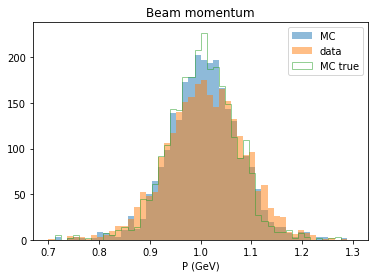

In [3]:
nmc = len(mcP); ndata = len(dataP)
print("MC selected events:", nmc, "\tData selected events:", ndata)
mcweight = np.ones_like(mcP)*ndata/nmc
#print("Cut:", precut + f" & (Beam Quality Cut)")

nnmc, xemc, _ = plt.hist(mcP, bins=50, alpha=0.5, label="MC", weights=mcweight, range=[momin,momax])
nndt, xedt, _ = plt.hist(dataP, bins=50, alpha=0.5, label="data", range=[momin,momax])
nnmc_t, xemc_t, _ = plt.hist(mcP_true, bins=50, alpha=0.5, label="MC true", weights=mcweight, range=[momin,momax], histtype="step")
plt.legend()
plt.title("Beam momentum")
plt.xlabel("P (GeV)")
plt.show()

In [4]:
def gauss_pdf(x, mu, sigma):
    return norm.pdf(x, mu, sigma)
def gauss_cdf(xe, mu, sigma):
    return norm.cdf(xe, mu, sigma)
def gauss_extpdf(x, mu, sigma, n):
    #return n, n*norm.pdf(x, mu, sigma)
    return n*norm.pdf(x, mu, sigma)

#c1 = cost.UnbinnedNLL(mcP, gauss_pdf)
#c2 = cost.UnbinnedNLL(dataP, gauss_pdf)
#c3 = cost.UnbinnedNLL(mcP_true, gauss_pdf)
#c1 = cost.BinnedNLL(nnmc, xemc, gauss_cdf)
#c2 = cost.BinnedNLL(nndt, xedt, gauss_cdf)
#c3 = cost.BinnedNLL(nnmc_t, xemc_t, gauss_cdf)
#c3 = cost.ExtendedUnbinnedNLL(mcP_true, gauss_extpdf)
c1 = cost.LeastSquares((xemc[1:]+xemc[:-1])/2, nnmc, np.maximum(np.sqrt(nnmc),1), gauss_extpdf)
c2 = cost.LeastSquares((xedt[1:]+xedt[:-1])/2, nndt, np.maximum(np.sqrt(nndt),1), gauss_extpdf)
c3 = cost.LeastSquares((xemc_t[1:]+xemc_t[:-1])/2, nnmc_t, np.maximum(np.sqrt(nnmc_t),1), gauss_extpdf)

'''m1 = Minuit(c1, mu=1, sigma=0.07)
#m1.fixed["cc"]=True
m1.migrad()
mu0inst = m1.values["mu"]
sigma0inst = m1.values["sigma"]
print(f"MC fitted (mu, sigma) = ({mu0inst}, {sigma0inst})")

m2 = Minuit(c2, mu=1, sigma=0.07)
m2.migrad()
muu = m2.values["mu"]
sigmaa = m2.values["sigma"]
print(f"Data fitted (mu, sigma) = ({muu}, {sigmaa})") # data

m3 = Minuit(c3, mu=1, sigma=0.07)
m3.migrad()
mu0 = m3.values["mu"]
sigma0 = m3.values["sigma"]
print(f"MC true fitted (mu, sigma) = ({mu0}, {sigma0})") # MC true'''

# Least Squares
m1 = Minuit(c1, mu=1, sigma=0.06, n=2000)
m1.migrad()
mu0inst = m1.values["mu"]; mu0inst_err = m1.errors["mu"]
sigma0inst = m1.values["sigma"]; sigma0inst_err = m1.errors["sigma"]
print(f"MC fitted (mu, sigma, n) = ({mu0inst:.4f}±{mu0inst_err:.4f}, {sigma0inst:.4f}±{sigma0inst_err:.4f}, {m1.values['n']:.1f}±{m1.errors['n']:.1f})")

m2 = Minuit(c2, mu=1, sigma=0.06, n=2000)
m2.migrad()
muu = m2.values["mu"]; muu_err = m2.errors["mu"]
sigmaa = m2.values["sigma"]; sigmaa_err = m2.errors["sigma"]
print(f"Data fitted (mu, sigma, n) = ({muu:.4f}±{muu_err:.4f}, {sigmaa:.4f}±{sigmaa_err:.4f}, {m2.values['n']:.1f}±{m2.errors['n']:.1f})")

m3 = Minuit(c3, mu=1, sigma=0.06, n=2000)
m3.migrad()
mu0 = m3.values["mu"]; mu0_err = m3.errors["mu"]
sigma0 = m3.values["sigma"]; sigma0_err = m3.errors["sigma"]
print(f"MC true fitted (mu, sigma, n) = ({mu0:.4f}±{mu0_err:.4f}, {sigma0:.4f}±{sigma0_err:.4f}, {m3.values['n']:.1f}±{m3.errors['n']:.1f})") # MC true

MC fitted (mu, sigma, n) = (1.0082±0.0012, 0.0634±0.0010, 31.4±0.6)
Data fitted (mu, sigma, n) = (1.0091±0.0015, 0.0737±0.0011, 31.6±0.6)
MC true fitted (mu, sigma, n) = (1.0033±0.0012, 0.0609±0.0009, 31.2±0.6)


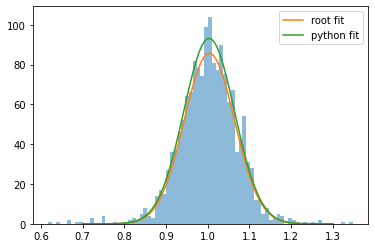

1814.1277661711474
-1867.8898313363172


In [5]:
aa,bb,_ = plt.hist(mcP_true, bins=80, alpha=0.5)
xx = np.linspace(0.7,1.3,100)

plt.plot(xx, norm.pdf(xx, 1.00386, 0.0603385)*85.6753*np.sqrt(2*np.pi)*0.0603385, label="root fit")
plt.plot(xx, norm.pdf(xx, mu0, sigma0)*len(mcP_true)*np.mean(np.diff(bb)), label="python fit")
plt.legend()
plt.show()
chi2 = 0
NLL = sum(-np.log(norm.pdf(mcP_true, mu0, sigma0)))
for ii in range(len(aa)):
    yy_root = norm.pdf((bb[ii]+bb[ii+1])/2, 1.00386, 0.0603385)*85.6753*np.sqrt(2*np.pi)*0.0603385
    yy_rootdensity = norm.pdf((bb[ii]+bb[ii+1])/2, 1.00386, 0.0603385)*len(mcP_true)*np.mean(np.diff(bb))
    yy_python = norm.pdf((bb[ii]+bb[ii+1])/2, mu0, sigma0)*len(mcP_true)*np.mean(np.diff(bb))
    chi2 += (aa[ii]-yy_rootdensity)**2#/np.maximum(aa[ii],1)
print(chi2)
print(NLL)

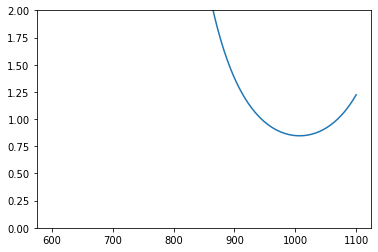

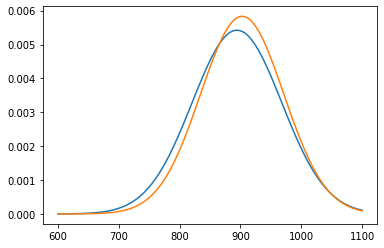

In [6]:
yy = np.linspace(600,1100,100)
plt.plot(yy, norm.pdf(yy, 1007, 68.17)/norm.pdf(yy, 1007, 57.7))
plt.ylim([0,2])
plt.show()
plt.plot(yy, norm.pdf(yy, 894.3, 73.55))
plt.plot(yy, norm.pdf(yy, 902.9, 68.37))

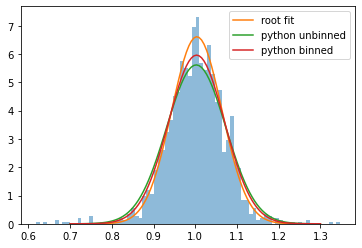

In [7]:
plt.hist(mcP_true, bins=80, alpha=0.5,density=True)
plt.plot(xx, norm.pdf(xx, 1.00386, 0.0603385), label="root fit")
plt.plot(xx, norm.pdf(xx, 1.0023940434185314, 0.07103640810407612), label="python unbinned")
plt.plot(xx, norm.pdf(xx, 1.0031953419820514, 0.0669145504342396), label="python binned")
plt.legend()
plt.show()

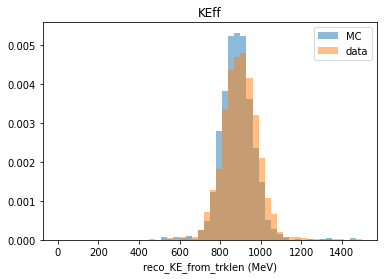

In [8]:
#MC_dXYZ = MCdistance[BQcut_MC]
#data_dXYZ = datadistance[BQcut_data]
MC_dXYZ = reco_KE_MC
data_dXYZ = reco_KE_data

plt.hist(MC_dXYZ,density=True,bins=50,alpha=0.5,label="MC", range=[0,1500])
plt.hist(data_dXYZ,density=True,bins=50,alpha=0.5,label="data", range=[0,1500])
plt.legend()
plt.title("KEff")
plt.xlabel("reco_KE_from_trklen (MeV)")
plt.show()

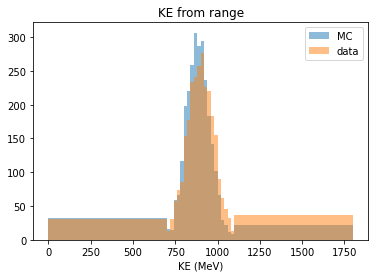

In [93]:
#dmin = 700; dmax = 1100
xbins = [0, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1800] # xbins for dXYZ Chi2 fit
nbins = len(xbins)-1
plt.hist(MC_dXYZ, bins=xbins, alpha=0.5, label="MC", weights=mcweight)
datahist, bin_edges, _ = plt.hist(data_dXYZ, bins=xbins, alpha=0.5, label="data")
plt.legend()
#plt.title("dXYZ")
#plt.xlabel("Distance (cm)")
plt.title("KE from range")
plt.xlabel("KE (MeV)")
plt.show()

def getChi2(mu=muu, sigma=sigmaa, mu0=mu0, sigma0=sigma0, wlimit = 3):
    deno = np.exp(-(mcP_true - mu0)**2/2/sigma0**2)#/sigma0
    numo = np.exp(-(mcP_true - mu)**2/2/sigma**2)#/sigma
    #numo = np.maximum(numo, wlimit)
    #print(sum(numo/deno))
    #print(len(numo/deno))
    #print(normfact)
    weight = numo/deno
    #normfact = len(numo)/sum(weight)
    #weight = weight*normfact
    weight = np.maximum(weight, 1/wlimit)
    weight = np.minimum(weight, wlimit)
    normfact = len(numo)/sum(weight) * mcweight
    weight = weight * normfact
    MChist, _ = np.histogram(MC_dXYZ, bins=xbins, weights=weight)
    chi2 = (datahist - MChist)**2/np.maximum(datahist + MChist, 1)
    return np.sum(chi2[1:-1])/(nbins-3), weight


In [94]:
mu_list = np.linspace(1, 1.03, 100)
sigma_list = np.linspace(0.06, 0.08, 100)
#mu_list = np.linspace(1.0075, 1.0225, 20)
#sigma_list = np.linspace(0.06, 0.07, 20)
mm, ss = np.meshgrid(mu_list, sigma_list)
Chi2 = np.zeros_like(mm)
for i in range(len(mm)):
    for j in range(len(mm[0])):
        Chi2[i,j], _ = getChi2(mm[i,j], ss[i,j])

Obtained mu = 1.01818 (res 0.0003)
Obtained sigma = 0.07192 (res 0.0002)


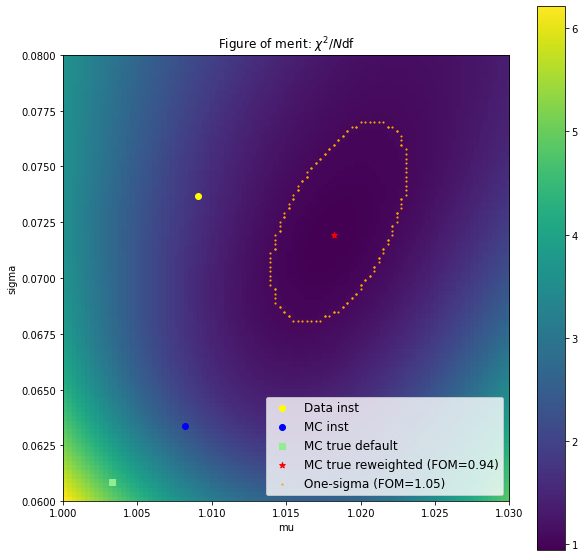

In [95]:
plt.figure(figsize=[10,10])
plt.imshow(Chi2,extent = [min(mu_list),max(mu_list),min(sigma_list),max(sigma_list)],origin="lower",aspect=(max(mu_list)-min(mu_list))/(max(sigma_list)-min(sigma_list)))
plt.colorbar()
plt.title(r"Figure of merit: $\chi^2/N{\rm df}$")
plt.xlabel("mu")
plt.ylabel("sigma")
plt.scatter([muu], [sigmaa], color="yellow", marker="o", label="Data inst")
plt.scatter([mu0inst], [sigma0inst], color="blue", marker="o", label="MC inst")
plt.scatter([mu0], [sigma0], color="lightgreen", marker="s", label="MC true default")
minChi2 = np.min(Chi2)
minidx = np.where(Chi2 == minChi2)
onesigmaChi2 = minChi2 + 2.30/(nbins-1) # Table 40.2 https://pdg.lbl.gov/2020/reviews/rpp2020-rev-statistics.pdf
onesigmaidx = []
for i in range(len(mm)):
    for j in range(len(mm[0])-1):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i,j+1]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i,j+1]>onesigmaChi2:
            onesigmaidx.append([i,j+1])
for i in range(len(mm)-1):
    for j in range(len(mm[0])):
        if Chi2[i,j]>onesigmaChi2 and Chi2[i+1,j]<onesigmaChi2:
            onesigmaidx.append([i,j])
        if Chi2[i,j]<onesigmaChi2 and Chi2[i+1,j]>onesigmaChi2:
            onesigmaidx.append([i+1,j])
mur = mm[minidx][0]
sigmar = ss[minidx][0]
print(f"Obtained mu = {mur:.5f} (res {np.average(mu_list[1:]-mu_list[:-1]):.2g})")
print(f"Obtained sigma = {sigmar:.5f} (res {np.average(sigma_list[1:]-sigma_list[:-1]):.2g})")
plt.scatter(mur, sigmar, color="r", marker="*", label=f"MC true reweighted (FOM={minChi2:.2f})")
plt.scatter(mm[tuple(np.transpose(onesigmaidx))], ss[tuple(np.transpose(onesigmaidx))], color="orange", marker=".", s=5, label=f"One-sigma (FOM={onesigmaChi2:.2f})")
plt.legend(fontsize=12, loc="lower right")
plt.show()

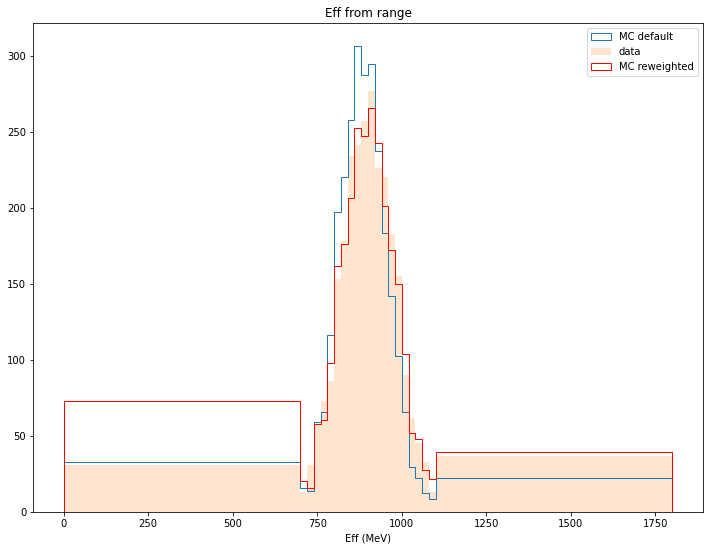

0.9403903508168494
0.9403903508168494
2.34776568841653


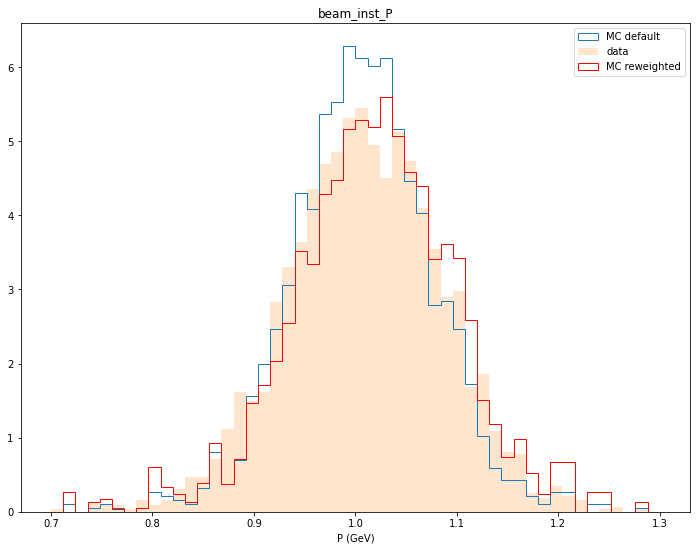

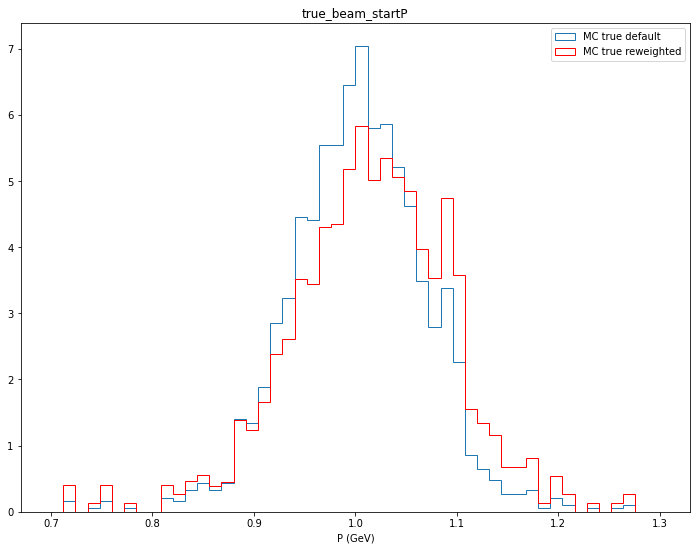

In [96]:
chi2, neweight = getChi2(mur, sigmar)
plt.figure(figsize=[12,9])
am,bm,_ = plt.hist(MC_dXYZ, density=False, bins=xbins, histtype="step", label="MC default", weights=mcweight)
aa,bb,_ = plt.hist(data_dXYZ, density=False, bins=xbins, alpha=0.2, label="data")
aw,bw,_ = plt.hist(MC_dXYZ, density=False, bins=xbins, histtype="step", label="MC reweighted", weights=neweight,color="r")
plt.legend()
plt.title("Eff from range")
plt.xlabel("Eff (MeV)")
plt.show()

print(chi2)
chi2 = 0
for ii in range(1,len(aa)-1):
    chi2 += (aw[ii]-aa[ii])**2/(aw[ii]+aa[ii])
print(chi2/(len(aa)-3))
print(sum(aa-aw))

nnbins = 50
plt.figure(figsize=[12,9])
amp,bmp,_ = plt.hist(mcP, bins=nnbins, histtype="step", label="MC default", weights=mcweight, range=[momin,momax], density=True)
aap,bbp,_ = plt.hist(dataP, bins=nnbins, alpha=0.2, label="data", range=[momin,momax], density=True)
awp,bwp,_ = plt.hist(mcP, bins=nnbins, histtype="step", label="MC reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend()
plt.title("beam_inst_P")
plt.xlabel("P (GeV)")
plt.show()

plt.figure(figsize=[12,9])
plt.hist(mcP_true, bins=nnbins, histtype="step", label="MC true default", weights=mcweight, range=[momin,momax], density=True)
plt.hist(mcP_true, bins=nnbins, histtype="step", label="MC true reweighted", weights=neweight, range=[momin,momax],color="r", density=True)
plt.legend()
plt.title("true_beam_startP")
plt.xlabel("P (GeV)")
plt.show()

In [97]:
cc1 = cost.LeastSquares((bm[1:]+bm[:-1])/2, am, np.maximum(np.sqrt(am),1), gauss_extpdf)
mm1 = Minuit(cc1, mu=1000, sigma=60, n=2000)
mm1.migrad()
print(f"MC fitted (mu, sigma) = ({mm1.values['mu']:.4f}±{mm1.errors['mu']:.4f}, {mm1.values['sigma']:.4f}±{mm1.errors['sigma']:.4f})")

cc2 = cost.LeastSquares((bw[1:]+bw[:-1])/2, aw, np.maximum(np.sqrt(aw),1), gauss_extpdf)
mm2 = Minuit(cc2, mu=1000, sigma=60, n=2000)
mm2.migrad()
print(f"Reweighted MC fitted (mu, sigma) = ({mm2.values['mu']:.4f}±{mm2.errors['mu']:.4f}, {mm2.values['sigma']:.4f}±{mm2.errors['sigma']:.4f})")

cc3 = cost.LeastSquares((bb[1:]+bb[:-1])/2, aa, np.maximum(np.sqrt(aa),1), gauss_extpdf)
mm3 = Minuit(cc3, mu=1000, sigma=60, n=2000)
mm3.migrad()
print(f"Data fitted (mu, sigma) = ({mm3.values['mu']:.4f}±{mm3.errors['mu']:.4f}, {mm3.values['sigma']:.4f}±{mm3.errors['sigma']:.4f})")

# beam_inst_P
cc6 = cost.LeastSquares((bmp[1:]+bmp[:-1])/2, amp, np.maximum(np.sqrt(amp),1), gauss_extpdf)
mm6 = Minuit(cc6, mu=1, sigma=0.06, n=2000)
mm6.migrad()
print(f"MC fitted (mu, sigma) = ({mm6.values['mu']:.4f}±{mm6.errors['mu']:.4f}, {mm6.values['sigma']:.4f}±{mm6.errors['sigma']:.4f})")

cc5 = cost.LeastSquares((bwp[1:]+bwp[:-1])/2, awp, np.maximum(np.sqrt(awp),1), gauss_extpdf)
mm5 = Minuit(cc5, mu=1, sigma=0.06, n=2000)
mm5.migrad()
print(f"Reweighted MC fitted (mu, sigma) = ({mm5.values['mu']:.4f}±{mm5.errors['mu']:.4f}, {mm5.values['sigma']:.4f}±{mm5.errors['sigma']:.4f})")

cc4 = cost.LeastSquares((bbp[1:]+bbp[:-1])/2, aap, np.maximum(np.sqrt(aap),1), gauss_extpdf)
mm4 = Minuit(cc4, mu=1, sigma=0.06, n=2000)
mm4.migrad()
print(f"Data fitted (mu, sigma) = ({mm4.values['mu']:.4f}±{mm4.errors['mu']:.4f}, {mm4.values['sigma']:.4f}±{mm4.errors['sigma']:.4f})")


MC fitted (mu, sigma) = (885.9128±1.3914, 69.4466±1.0806)
Reweighted MC fitted (mu, sigma) = (899.9534±1.6372, 79.0666±1.3438)
Data fitted (mu, sigma) = (898.8778±1.6318, 79.6974±1.3360)
MC fitted (mu, sigma) = (1.0076±0.0080, 0.0637±0.0068)
Reweighted MC fitted (mu, sigma) = (1.0199±0.0091, 0.0728±0.0083)
Data fitted (mu, sigma) = (1.0102±0.0091, 0.0742±0.0080)


(array([526., 205., 123.,  99.,  80.,  62.,  51.,  44.,  36.,  31.,  20.,
         19.,  16.,  16.,  19.,  16.,  14.,  21.,  16.,   9.,  11.,   8.,
          5.,   9.,   8.,   8.,   2.,   5.,   3.,   2.,   1.,   2.,   5.,
          1.,   3.,   2.,   1.,   3.,   1.,   2.,   0.,   0.,   2.,   1.,
          0.,   1.,   1.,   4.,   1.,  43.]),
 array([1.33634393, 1.39606348, 1.45578304, 1.51550259, 1.57522215,
        1.6349417 , 1.69466126, 1.75438082, 1.81410037, 1.87381993,
        1.93353948, 1.99325904, 2.0529786 , 2.11269815, 2.17241771,
        2.23213726, 2.29185682, 2.35157637, 2.41129593, 2.47101549,
        2.53073504, 2.5904546 , 2.65017415, 2.70989371, 2.76961326,
        2.82933282, 2.88905238, 2.94877193, 3.00849149, 3.06821104,
        3.1279306 , 3.18765015, 3.24736971, 3.30708927, 3.36680882,
        3.42652838, 3.48624793, 3.54596749, 3.60568704, 3.6654066 ,
        3.72512616, 3.78484571, 3.84456527, 3.90428482, 3.96400438,
        4.02372394, 4.08344349, 4.14316305, 4.

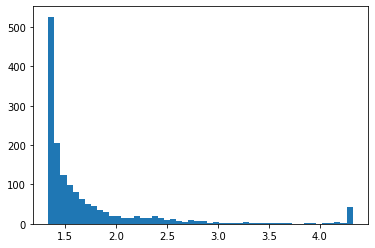

In [90]:
plt.hist(neweight,bins=50)